# Capstone : Forecasting Water Levels in Chennai India


*By: Asher Lewis* [Github](https://github.com/abrahamlewis4867)

<img src="../assets/D9HGx7FVUAEawA-.jpeg" width="1400px">

## Problem Statement

For this project we are going to try to forecast the monthly water level for Chennai India’s 4 main reservoirs in Chennai India. We are going to score are predictions using RMSE. The goal is to have the model do well enough that it gets a RMSE of above an 80.

On 19 June 2019, Chennai city officials declared that "Day Zero", or the day when almost no water is left, had been reached, as all the four main reservoirs supplying water to the city had run dry.

## Executive Summary


---

## Table of Contents


1. [Data Dictionary](#Data-Dictionary)
1. [Loading packages and data](#Loading-packages-and-data)
1. [Data Cleaning](#Data-Cleaning)
1. [EDA](#EDA)
1. [Model Preparation](#Model-Preparation)
1. [Modeling](#Modeling)
 - [Baseline](#Basline)
1. [Model evaluation](#Model-evaluation)
1. [Conclusions and Recommendations](#Conclusions-and-Recommendations)
2. [References](#References)

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|fire_id|object|fire.csv| Sequential unique whole numbers that are automatically generated and serve as an ID|
|fire_name|object|fire.csv| Name of fire (UNNAMED if not identifiable from source fire occurrence databases)|
|asmnt_type|object|fire.csv| Fire mapping assessment strategy (Initial (SS) (SS=single scene), Initial, or Extended)|

Red Hills, Cholavaram, Poondi and Chembarambakkam, with a combined capacity of 11,057 mcft. These are the major sources of fresh water for the city.

## Loading packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

import seaborn as sns
sns.set_style("darkgrid")

In [2]:
reserv= pd.read_csv("../data/chennai_reservoir_levels.csv")

In [23]:
reserv.shape

(5836, 5)

In [3]:
rain = pd.read_csv("../data/chennai_reservoir_rainfall.csv")

In [24]:
rain.shape

(5836, 5)

In [4]:
pop = pd.read_csv("../data/csvData.csv")

In [5]:
consump = pd.read_csv("../data/WaterConsumptionChennaiason31Jan2019.csv")

## Cleaning

In [6]:
reserv.rename(columns={"POONDI": "Poondi_water_level", 
                     "CHOLAVARAM": "Cholavaram_water_level",
                     "REDHILLS": "Redhills_water_level",
                    "CHEMBARAMBAKKAM": "Chembarambakkam_water_level"},inplace =True)

In [7]:
rain.rename(columns={"POONDI": "Poondi_rain", 
                     "CHOLAVARAM": "Cholavaram_rain",
                     "REDHILLS": "Redhills_rain",
                    "CHEMBARAMBAKKAM": "Chembarambakkam_rain"},inplace =True)

In [8]:
df = pd.merge(reserv, rain ,on ="Date", how="outer") 

In [9]:
cols = df.columns.tolist()

In [10]:
water_cols =  ['Poondi_water_level',
 'Cholavaram_water_level',
 'Redhills_water_level',
 'Chembarambakkam_water_level']

In [11]:
rain_cols =['Poondi_rain',
 'Cholavaram_rain',
 'Redhills_rain',
 'Chembarambakkam_rain']

In [12]:
df = df[['Date', 'Poondi_water_level','Poondi_rain','Cholavaram_water_level',
   'Cholavaram_rain', 'Redhills_water_level', 'Redhills_rain', 'Chembarambakkam_water_level','Chembarambakkam_rain'  ]]

In general it is good not to have any null values, but when we model later it will be imperative that we have no null values, as our models won’t be able to function properly if the data contains null values.

In [13]:
df.isna().sum()

Date                           0
Poondi_water_level             0
Poondi_rain                    0
Cholavaram_water_level         0
Cholavaram_rain                0
Redhills_water_level           0
Redhills_rain                  0
Chembarambakkam_water_level    0
Chembarambakkam_rain           0
dtype: int64

In [14]:
df

,Date,Poondi_water_level,Poondi_rain,Cholavaram_water_level,Cholavaram_rain,Redhills_water_level,Redhills_rain,Chembarambakkam_water_level,Chembarambakkam_rain
0,01-01-2004,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0
1,02-01-2004,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0
2,03-01-2004,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0
3,04-01-2004,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0
4,05-01-2004,3.8,0.0,0.0,0.0,267.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5831,19-12-2019,1535.0,0.0,139.0,0.0,2318.0,0.0,1397.0,0.0
5832,20-12-2019,1529.0,0.0,131.0,0.0,2335.0,0.0,1435.0,0.0
5833,21-12-2019,1522.0,0.0,123.0,0.0,2351.0,0.0,1473.0,0.0
5834,22-12-2019,1514.0,0.0,115.0,0.0,2369.0,0.0,1510.0,0.0


---

For this project we are going to be visualizing and modeling time series data, so we shall now provide and explanation of what time series data is.

### Explanation of Time Series Data

A time series simply put is series of data points ordered in time.
In a time series, time is usually the independent feature and the desired goal is to make a forecast with our target feature about the future.In our project the “Date” feature in our dataset will serve as our time feature and the reservoirs’s water level will serve as the target feature that we are trying to forecast. Time-series can be used for forecasting and inference. For this project we are going to be focusing on forecasting.

Later on in the project, before the modeling, we will go more in depth in as to what requirements our time series data should meet and what we have to implement in order to get a good model.

### Formatting data to time series
---

We are a now going to go though the necessary steps in order to convert our data into time series data and make sure that our data is proper to use in a time series 

#### Step 1.  Formatting the date into a datetime

The first thing we have to do in order to setup our data into functional Time Series is format the “Date” feature in our data set from a string to a date time data type. The DATETIME data type is used for values that contain both date and time parts in our case that only means years, months and days. We are going to convert “Date”  by making use of the pandas library to convert it to a date time. Additionally, we are also going to change the format from the data’s Indian order of Day/Month/Year to Month/Day/Year.

In [15]:
df["Date"].dtype

dtype('O')

As can be seen the datatype for “Date” is O which stands for Object and is a string and not a DateTime datatype.

In [16]:
df["Date"] = pd.to_datetime(reserv["Date"], format='%d-%m-%Y') #Chaning the format to the American order

In [17]:
df["Date"].dtype

dtype('<M8[ns]')

In [21]:
df.dtypes

Date                           datetime64[ns]
Poondi_water_level                    float64
Poondi_rain                           float64
Cholavaram_water_level                float64
Cholavaram_rain                       float64
Redhills_water_level                  float64
Redhills_rain                         float64
Chembarambakkam_water_level           float64
Chembarambakkam_rain                  float64
dtype: object

As can be see above we have successfully converted the “Date” data to a datetime. 

Above pandas dataframe attribute "dtypes" shows that Datetime64[ns] is the general dtype. This means that the data is stored as 64-bit integers, in units of nanoseconds (ns)This data structure allows the pandaslibrary to compactly store large sequences of date/time values and efficiently perform vectorized operations using NumPy datetime64 arrays.is the general dtype. The attribute from the pandas series shows that The <M8[ns] is the specific dtype. General dtypes map to specific dtypes and they are not really different [source](https://stackoverflow.com/questions/29206612/difference-between-data-type-datetime64ns-and-m8ns)


#### Step 2 Setting our index into DatetimeIndex

We now are going to set our data's index to our datetime column.


In [28]:
df.set_index("Date", inplace= True)

Setting the our index to the datetime feature allows us to make use of pandas' time-based indexing. For example if we wanted to look at the data on "Day Zero", June 16, 2019, when Chennai city officials declared that all the four main reservoirs supplying water to the city had run dry. We can simply do that using pandas' loc method.

In [34]:
df.loc['2019-06-19']

Poondi_water_level             23.0
Poondi_rain                     0.0
Cholavaram_water_level          0.0
Cholavaram_rain                 0.0
Redhills_water_level            0.0
Redhills_rain                   0.0
Chembarambakkam_water_level     1.0
Chembarambakkam_rain            0.0
Name: 2019-06-19 00:00:00, dtype: float64

Another thing setting the index to DatetimeIndex will accomplish  is making plotting easier as will be demonstrated during the Exploratory Data Analysis. 

#### Step 3. Making sure the DatetimeIndex is properly in order

In order for our time series data to be interpreted and modeled properly in it imperative that the dates are in order. This intuitively makes sense if the dates weren’t in order than the dates lose their value as holding a value to an ordred constant.

In [36]:
df.head()

,Poondi_water_level,Poondi_rain,Cholavaram_water_level,Cholavaram_rain,Redhills_water_level,Redhills_rain,Chembarambakkam_water_level,Chembarambakkam_rain
Date,,,,,,,,
2004-01-01,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0
2004-01-02,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0
2004-01-03,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0
2004-01-04,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0
2004-01-05,3.8,0.0,0.0,0.0,267.0,0.0,0.0,0.0


In [35]:
df.sort_index(inplace = True)

In [37]:
df.head()

,Poondi_water_level,Poondi_rain,Cholavaram_water_level,Cholavaram_rain,Redhills_water_level,Redhills_rain,Chembarambakkam_water_level,Chembarambakkam_rain
Date,,,,,,,,
2004-01-01,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0
2004-01-02,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0
2004-01-03,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0
2004-01-04,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0
2004-01-05,3.8,0.0,0.0,0.0,267.0,0.0,0.0,0.0


#### Step 4.  Checking the time-series has constant frequency

Lastly we need to check that our time series data has a constant frequency of dates. If that was not the case then we could have it that some of our data has only partial frequency.  For example if our some of data was only monthly and some of our data was daily than our data would give the same weight to the months and the days even though they are on different scales.

In [38]:
df.index.inferred_freq

'D'

The "D" that was returned is showing us that indeed are data is constant and its frequency is daily.

Having converted our data to time-series that we can now preceed on to the Exploratory Data Analysis.

---

## EDA

In [18]:
df.dtypes

Poondi_water_level             float64
Poondi_rain                    float64
Cholavaram_water_level         float64
Cholavaram_rain                float64
Redhills_water_level           float64
Redhills_rain                  float64
Chembarambakkam_water_level    float64
Chembarambakkam_rain           float64
dtype: object

In [19]:
df.shape

(5836, 8)

In [20]:
df.describe()

,Poondi_water_level,Poondi_rain,Cholavaram_water_level,Cholavaram_rain,Redhills_water_level,Redhills_rain,Chembarambakkam_water_level,Chembarambakkam_rain
count,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000
mean,1116.271270,3.464402,234.265965,3.758773,1533.680166,3.828992,1285.674289,4.012688
std,1020.316805,13.065897,272.289990,14.267783,906.251292,15.011809,964.355749,16.251079
min,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,200.225000,0.000000,18.375000,0.000000,791.000000,0.000000,408.000000,0.000000
50%,775.500000,0.000000,91.000000,0.000000,1596.000000,0.000000,1190.000000,0.000000
75%,1975.000000,0.000000,445.000000,0.000000,2212.250000,0.000000,2047.000000,0.000000
max,3231.000000,300.000000,896.000000,293.000000,3300.000000,320.000000,3396.000000,475.000000


In [21]:
put note about total water capcity

SyntaxError: invalid syntax (<ipython-input-21-2c5ae3d2970d>, line 1)

In [22]:
df.eq(0).sum()

Poondi_water_level                0
Poondi_rain                    4647
Cholavaram_water_level         1207
Cholavaram_rain                4780
Redhills_water_level            206
Redhills_rain                  4701
Chembarambakkam_water_level     424
Chembarambakkam_rain           4720
dtype: int64

The first thing to notice is that there are a lot of zeros in the data.

In [23]:
def graph_percentile(col):
    # Generate random data
    data = col

    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    # Plot the Histogram from the random data
    fig, ax = plt.subplots(figsize=(8,8))

    '''
    counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
    bins    = numpy.ndarray of bin edge/range values
    patches = a list of Patch objects.
            each Patch object contains a Rectnagle object. 
            e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
    '''
    counts, bins, patches = ax.hist(data, facecolor=perc_50_colour, edgecolor='gray')


    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins.round(2))
    plt.xticks(rotation=70)

    # Set the graph title and axes titles
    plt.title('Distribution of rainfall for Chembarambakkam reservoir in millimetres', fontsize=20)
    plt.ylabel('Count of Distribution', fontsize=15)
    plt.xlabel('Amount rainfall in millimetres', fontsize=15)

    # Change the colors of bars at the edges
    twentyfifth, seventyfifth, ninetyfifth = np.percentile(data, [25, 75, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor(perc_25_colour)
        elif leftside > ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        elif leftside > seventyfifth:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    # Annotation for bar values
    ax.annotate('Each bar shows count and percentage of total',
                xy=(.85,.30), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=10, bbox=dict(boxstyle="round", fc="white"),
                rotation=-90)

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))




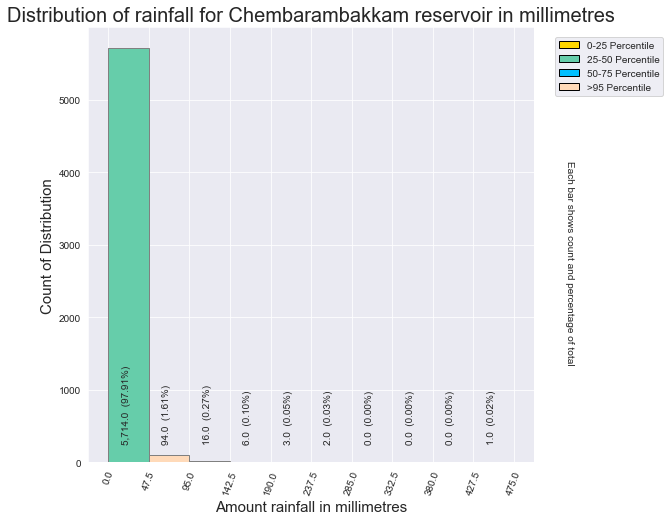

In [24]:
graph_percentile(df["Chembarambakkam_rain"])

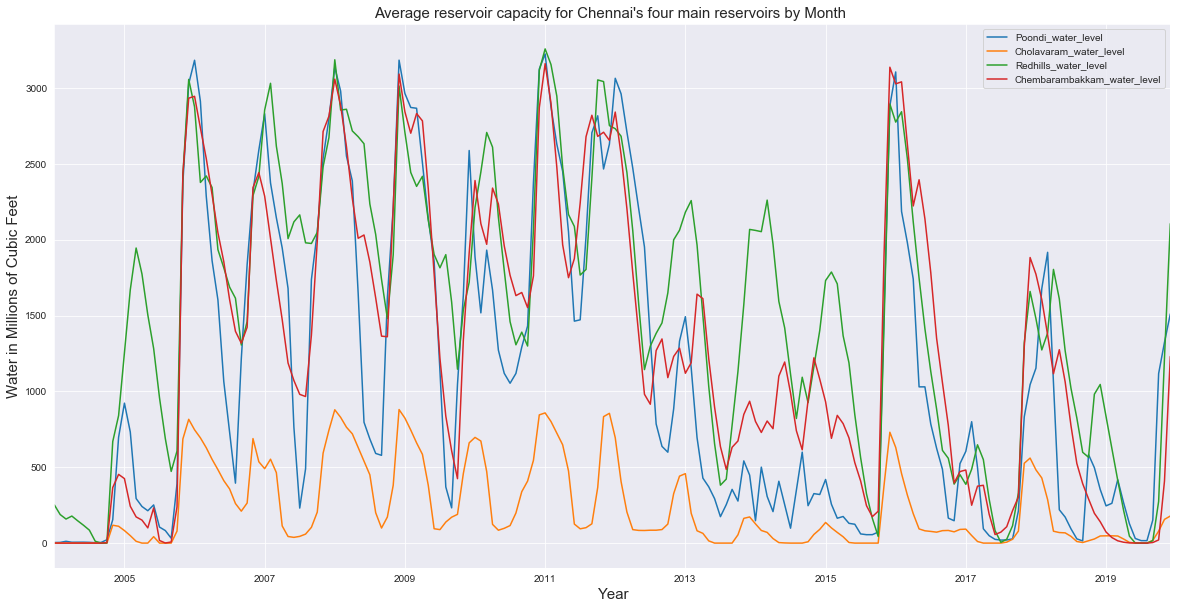

In [25]:
df[water_cols].resample("m").mean().plot(figsize=(20,10))
plt.title("Average reservoir capacity for Chennai's four main reservoirs by Month " ,fontsize=15)
plt.xlabel("Year",fontsize=15)
plt.ylabel("Water in Millions of Cubic Feet",fontsize=15);

In [26]:
note about resamplein

SyntaxError: invalid syntax (<ipython-input-26-8dcb41a6933e>, line 1)

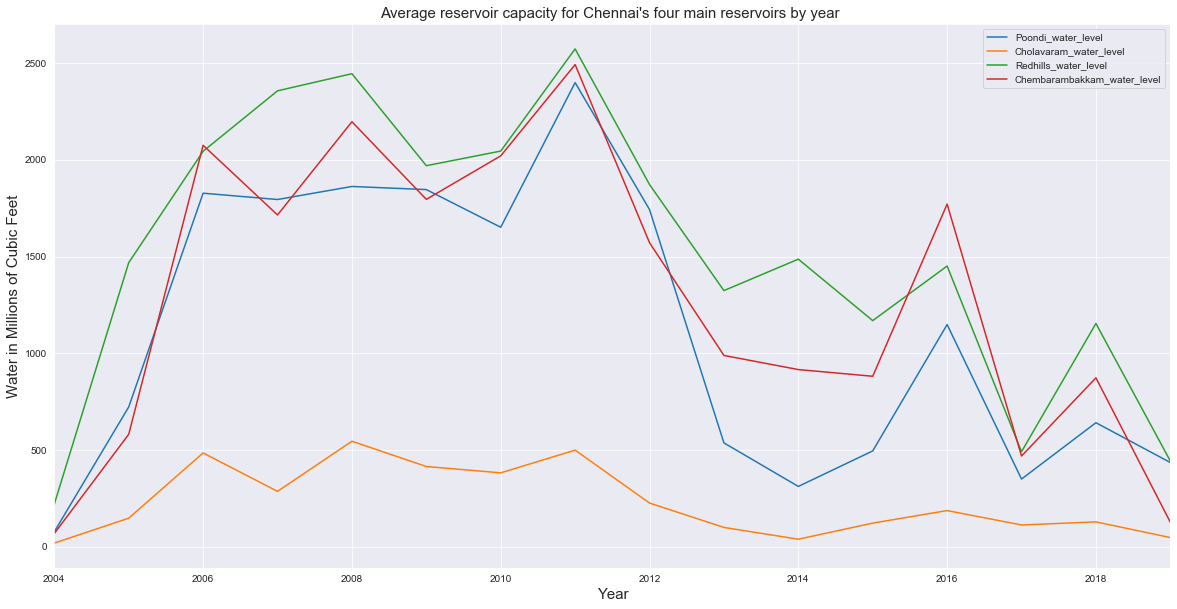

In [27]:
df[water_cols].resample("y").mean().plot(figsize=(20,10))
plt.title("Average reservoir capacity for Chennai's four main reservoirs by year " ,fontsize=15)
plt.xlabel("Year",fontsize=15)
plt.ylabel("Water in Millions of Cubic Feet",fontsize=15);

---

## A further Explanation of Time-series Data

Before we apply our models we need to go and explain a bit more about time-series data. There are several things that we would want to test our data for including:  

*Is the data stationary?*

*Is there seasonality in the data?*

*Is the target variable autocorrelated?*

### Determining and Understanding Stationary

Stationarity is an important characteristic of time series. A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time.

Ideally, we want to have a stationary time series for modelling. Of course, not all of them are stationary, but we can make different transformations to make them stationary.

A way of determining stationary is to apply the Augmented Dickey-Fuller test.

The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity.   
  
The hypotheses for the test:

* The null hypothesis for this test is that there is a unit root 
  
* The alternate hypothesis differs slightly according to which equation you’re using. The basic alternate is that the time series is stationary (or trend-stationary)

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$


- Therefore, a **small $p$-value** (**<.05**) would give us evidence and tell us to reject the null hypothesis, meaning we accept that **our time series is stationary**

In [50]:
# from arima_SOLUTION Mahdi Shadkam-Farrokhi
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

Based on the explanation above only Chembarambakkam lake is  stationary

In [51]:
interpret_dftest(df_m['Chembarambakkam_water_level'])

Test Statistic   -3.983308
p-value           0.001500
dtype: float64

In [52]:
interpret_dftest(df_m['Poondi_water_level'])

Test Statistic   -2.181849
p-value           0.212899
dtype: float64

In [53]:
interpret_dftest(df_m['Redhills_water_level'])

Test Statistic   -2.523767
p-value           0.109798
dtype: float64

In [54]:
interpret_dftest(df_m['Cholavaram_water_level'])

Test Statistic   -2.440407
p-value           0.130655
dtype: float64

In [ ]:
A way of getting around the problem of 

### An Explanation of lags and Autocorrelation and Partial-autocorrelation 

First of all we need to explain what lags are and what lagging the data does.    
Simply put A “lag” is a fixed amount of passing time; One set of observations in a time series lagged against a second, later set of data. The kth lag is the time period that happened “k” time points before time i. For example: Lag1(Y2) = Y1 and Lag4(Y9) = Y5.[source](https://www.statisticshowto.com/lag-plot/#:~:text=A%20%E2%80%9Clag%E2%80%9D%20is%20a%20fixed,Y9).  

In our data set this would translate to what the water level was in a reservoir lagged before to this period of time.



A significant cross-correlation at a positive lag indicates that the independent variable may be significant when lagged by that number of periods.



We can use the Autocorrelation Function (ACF) plot and Partial-autocorrelation (PACF) plot to better visualize the shape of our time-series data.

In [44]:
df_m = df.resample("m").mean()

In [40]:
df.columns

Index(['Poondi_water_level', 'Poondi_rain', 'Cholavaram_water_level',
       'Cholavaram_rain', 'Redhills_water_level', 'Redhills_rain',
       'Chembarambakkam_water_level', 'Chembarambakkam_rain'],
      dtype='object')

In [ ]:
Explaining what staionanry 






Autocorrelation and Partial Autocorrelation
The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF) For example the ACF for a time series yt is given by:

Corr(yt,yt−k),k=1,2,....
This value of k is the time gap being considered and is called the lag. A lag 1 autocorrelation (i.e., k = 1 in the above) is the correlation between values that are one time period apart. More generally, a lag k autocorrelation is the correlation between values that are k time periods apart.

The ACF is a way to measure the linear relationship between an observation at time t and the observations at previous times. If we assume an AR(k) model, then we may wish to only measure the association between yt and yt−k and filter out the linear influence of the random variables that lie in between (i.e., yt−1,yt−2,…,yt−(k−1)), which requires a transformation on the time series. Then by calculating the correlation of the transformed time series we obtain the partial autocorrelation function (PACF).

The PACF is most useful for identifying the order of an autoregressive model. Specifically, sample partial autocorrelations that are significantly different from 0 indicate lagged terms of y that are useful predictors of yt. It is important that the choice of the order makes sense. For example, suppose you have blood pressure readings for every day over the past two years. You may find that an AR(1) or AR(2) model is appropriate for modeling blood pressure. However, the PACF may indicate a large partial autocorrelation value at a lag of 17, but such a large order for an autoregressive model likely does not make much sense.

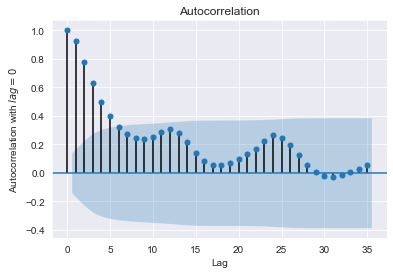

In [44]:
plot_acf(df_m['Chembarambakkam_water_level'], lags =35 )
plt.xlabel("Lag")
plt.ylabel("Autocorrelation with $lag = 0$");

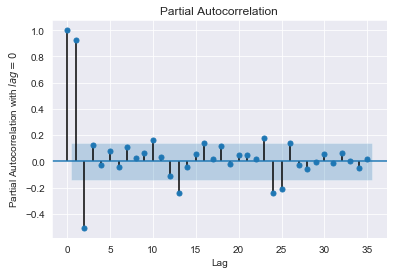

In [42]:
plot_pacf(df_m['Chembarambakkam_water_level'], lags = 35)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation with $lag = 0$");

### Seasonality

In time series data, **seasonality** describes when a time series is affected by factors that take on a **fixed and known frequency**.

Seasonality does not have to explicitly refer to seasons of the year (and from an inclusivity standpoint, different regions of the world have different seasons), but seasonality almost always **will** be tied to some meaning on the calendar!

### Engineering features

In [56]:
dfm["time"] = range(len(df))

NameError: name 'dfm' is not defined

In [23]:
def multi_lag_appender(df, column, lags, inplace = False):
    '''Appends the appropriate lag from the list of given lags to the give dataframe'''
    # copying datafame unless inplace = True
    df = df if inplace else df.copy()
    for lag in lags:
        df[f"{column}_{lag}"] = df[column].shift(lag)
    
    return None if inplace else df

In [59]:
desired_lags = [1, 2, 10, 16, 23, 25]
reserv_with_lags = multi_lag_appender(dfy, "Chembarambakkam_water_level", desired_lags)
reserv_with_lags.head(14)

,Poondi_water_level,Poondi_rain,Cholavaram_water_level,Cholavaram_rain,Redhills_water_level,Redhills_rain,Chembarambakkam_water_level,Chembarambakkam_rain,Chembarambakkam_water_level_1,Chembarambakkam_water_level_2,Chembarambakkam_water_level_10,Chembarambakkam_water_level_16,Chembarambakkam_water_level_23,Chembarambakkam_water_level_25
Date,,,,,,,,,,,,,,
2004-01-31,3.738710,2.064516,0.000000,0.225806,252.161290,0.612903,0.000000,0.677419,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-29,4.568966,0.000000,0.000000,0.000000,188.275862,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2004-03-31,11.850323,0.000000,0.000000,0.000000,158.612903,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2004-04-30,5.576667,0.700000,0.000000,0.000000,178.236667,0.000000,0.000000,0.166667,0.000000,0.000000,NaN,NaN,NaN,NaN
2004-05-31,5.780645,7.193548,0.000000,7.032258,147.009677,7.903226,0.000000,7.096774,0.000000,0.000000,NaN,NaN,NaN,NaN
2004-06-30,5.956667,1.766667,0.000000,1.733333,117.446667,1.500000,0.000000,0.733333,0.000000,0.000000,NaN,NaN,NaN,NaN
2004-07-31,4.987097,1.354839,0.000000,2.548387,85.309677,1.012903,0.000000,0.967742,0.000000,0.000000,NaN,NaN,NaN,NaN
2004-08-31,2.464516,0.903226,0.000000,1.806452,12.193548,0.838710,0.000000,0.290323,0.000000,0.000000,NaN,NaN,NaN,NaN
2004-09-30,4.275000,6.733333,0.000000,5.233333,0.000000,7.100000,0.000000,4.266667,0.000000,0.000000,NaN,NaN,NaN,NaN




## Model Preparation

In [60]:
reserv_with_lags.dropna(inplace= True)

In [61]:
X = reserv_with_lags.drop(columns=cols[1:])
y = reserv_with_lags["Chembarambakkam_water_level"]

# must NOT shuffle for time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .26, shuffle = False)

### Baseline

In [62]:
dumb = DummyRegressor(strategy='mean')

In [63]:
y_train.mean()

1691.1020610666906

In [64]:
dumb.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [65]:
dumb.score(X_train, y_train)

0.0

In [66]:
dumb.score(X_test, y_test)

-2.454368799516066

### Linear Regression

In [67]:
# instantiate
lr = LinearRegression()

# fit (original model fitted)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
lr.score(X_train, y_train)

0.8717415569435063

In [69]:
lr.score(X_test, y_test)

0.8362128101077196

In [70]:
X = reserv_with_lags.drop(columns=cols[1:])

X = sm.add_constant(X) # MUST add constant for statsmodels

y = reserv_with_lags["Chembarambakkam_water_level"]

# must NOT shuffle for time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)

In [80]:
X

,const,Chembarambakkam_water_level_1,Chembarambakkam_water_level_2,Chembarambakkam_water_level_10,Chembarambakkam_water_level_16,Chembarambakkam_water_level_23,Chembarambakkam_water_level_25
Date,,,,,,,
2006-02-28,1.0,2946.451613,2934.193548,151.600000,2.967742,0.000000,0.000000
2006-03-31,1.0,2737.428571,2946.451613,100.322581,366.633333,0.000000,0.000000
2006-04-30,1.0,2536.903226,2737.428571,231.800000,453.129032,0.000000,0.000000
2006-05-31,1.0,2297.466667,2536.903226,17.129032,425.322581,0.000000,0.000000
2006-06-30,1.0,2046.677419,2297.466667,0.645161,243.107143,0.000000,0.000000
...,...,...,...,...,...,...,...
2019-08-31,1.0,0.000000,0.833333,291.774194,1116.700000,214.233333,72.322581
2019-09-30,1.0,0.000000,0.000000,196.533333,1275.290323,303.612903,107.935484
2019-10-31,1.0,3.733333,0.000000,141.000000,1063.133333,1293.900000,214.233333


In [71]:
# instantiate
ols = sm.OLS(y_train, X_train) # notice y goes first!

# fit
fitted_ols = ols.fit() # returned model is fitted, not the original!

In [72]:
fitted_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Chembarambakkam_water_level   R-squared:                       0.874
Model:                                     OLS   Adj. R-squared:                  0.868
Method:                          Least Squares   F-statistic:                     145.2
Date:                         Thu, 03 Sep 2020   Prob (F-statistic):           4.00e-54
Time:                                 13:57:52   Log-Likelihood:                -941.14
No. Observations:                          133   AIC:                             1896.
Df Residuals:                              126   BIC:                             1917.
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            170.3499     86.462      1.970      0.051      -0.756     341.456
Chembarambakkam_water_level_1      1.3873      0.076     18.302      0.000       1.237       1.537
Chembarambakkam_water_level_2     -0.5347      0.077     -6.925      0.000      -0.688      -0.382
Chembarambakkam_water_level_10     0.0349      0.033      1.050      0.296      -0.031       0.101
Chembarambakkam_water_level_16    -0.0023      0.033     -0.070      0.944      -0.068       0.064
Chembarambakkam_water_level_23     0.0919      0.049      1.860      0.065      -0.006       0.190
Chembarambakkam_water_level_25    -0.0848      0.047     -1.819      0.071      -0.177       0.007
==============================================================================
Omnibus:                       58.943   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.625
Skew:                           1.659   Prob(JB):                     3.31e-43
Kurtosis:                       7.928   Cond. No.                     1.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
y_train_preds = fitted_ols.predict(X_train)
r2_score(y_train, y_train_preds)

0.87364739059987

In [74]:
y_test_preds = fitted_ols.predict(X_test)
r2_score(y_test, y_test_preds)

0.857953898526969

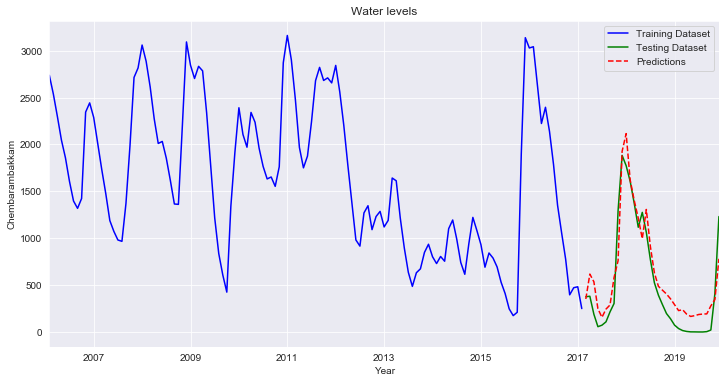

In [75]:
# Get forecasts for testing set
preds = fitted_ols.predict(X_test)

plt.figure(figsize=(12,6))
plt.title("Water levels")

# Plot time series predictions against actual values for ENTIRE dataset
y_train.plot(style="b")
y_test.plot(style="g")
preds.plot(style="r--") # red with dash
plt.xlabel("Year")
plt.ylabel("Chembarambakkam")
plt.legend(labels = ["Training Dataset", "Testing Dataset", "Predictions"]);

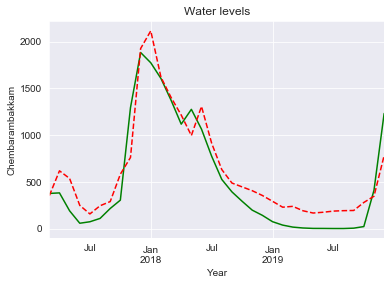

In [76]:
y_test.plot(style='g') 
preds.plot(style='r--')
plt.xlabel("Year")
plt.ylabel("Chembarambakkam")
plt.title("Water levels");

## Conclusions and Recommendations

## References